# Preprocessing
Ali Zolfagharian

# Libraries, connecting to data source

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pickle

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/dataiku

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/dataiku'
/content/drive/MyDrive/dataiku


# Reading csv data, and make it ready for preprocessing

reading census income learn csv files (training and test), and removing space from the beginning as it appeared in raw data

In [236]:
data = pd.read_csv('data/census_income_learn_edited.csv',skipinitialspace=True)
test_data = pd.read_csv('data/census_income_test_edited.csv',skipinitialspace=True)


In [237]:
def prep_data(_data):
  '''get a dataframe, then it replace not in universe and ? to np.nan, and makes some numerical columns to categorical, 
     it removes columns with many missing values, and turn target columns to a binary 0 and 1'''
  _data = _data.replace(['?','Not in universe'], np.NaN);
  columns_to_non_numerical = ["year", "fill inc questionnaire for veteran's admin", "veterans benefits", "detailed industry recode", "detailed occupation recode"]
  for a_col in columns_to_non_numerical:
    _data[a_col] = _data[a_col].astype(str)
  _data_nul = (_data.isna().sum()*100 / len(_data))
  data_missing_columns = np.array((_data_nul[_data_nul>30]).index.tolist())
  _data = _data.drop(columns=data_missing_columns)
  _data = _data.replace(['-50000','50000+.'],['0','1'])
  return _data

In [238]:
data = prep_data(data)
test_data = prep_data(test_data)

In [239]:
numerical_features = (data.select_dtypes(include=np.number).columns.tolist())
datnumer = data[numerical_features].copy()
data = data.drop(columns=numerical_features)
data[numerical_features] = datnumer[numerical_features]

In [240]:
X_train = data.drop(columns='income')
y_train = data['income']
X_test = test_data.drop(columns='income')
y_test = test_data['income']

In [241]:
set_config(display='diagram')
categorical_features = (X_train.select_dtypes(exclude=np.number).columns.tolist())
assert(len(numerical_features)+len(categorical_features)==len(X_train.columns.tolist()))

In [242]:
encoded_X_train = X_train.copy()

For numercial data, we use simple imputer to insert mean instead of the missing value
and we use standardscaler for scaling

In [243]:
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
num_transformer

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [244]:
num_transformer.fit(X_train[numerical_features]);

In [245]:
encoded_X_train[numerical_features] = num_transformer.transform(X_train[numerical_features])

For categorical data, we use simpleimputer to insert most frequent instead of missing value

In [246]:
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
cat_transformer

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder())])

In [247]:
cat_transformer.fit(X_train[categorical_features]);

In [248]:
new_features_names = cat_transformer[-1].get_feature_names_out()
len(new_features_names)

365

In [249]:
encoded_X_train[new_features_names] = pd.DataFrame(cat_transformer.transform(X_train[categorical_features]).toarray(),columns=new_features_names);

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [250]:
encoded_X_train = encoded_X_train.drop(columns=categorical_features);

In [251]:
cols = encoded_X_train.columns.tolist();

let have name of original feature for each new feature. It has been added as x<i>_<value in the categorical columns> and we onle need to say what is x<i>. For instance x0 is 'detailed industry recode'

In [252]:
to_original_feature = {}
for i in range (20):
  to_original_feature[f'x{i}']=categorical_features[i]

# Preprocessing in one pipeline

In [253]:
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
preprocessor = make_column_transformer(
    (num_transformer, numerical_features),
    (cat_transformer, categorical_features),
    remainder='passthrough'
)
preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'wage per hour', 'capital gains',
                                  'capital losses', 'divdends from stocks',
                                  'instance weight',
                                  'num persons worked for employer',
                                  'weeks worked in year']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  Sim...
                                  'marital status', 'major industry code',
                                  'race', 'hispanic Origin', 'sex',
                                  'full or part time employment stat',
                                  'tax filer status',
                                  'detailed household and family stat',
                                  'detailed household summary in household',
                                  'live in this house 1 year ago',
                                  'country of birth father',
                                  'country of birth mother',
                                  'country of birth self', 'citizenship',
                                  'veterans benefits',
                                  "fill inc questionnaire for veteran's admin",
                                  'year'])])

In [254]:
pr_fit_tr = (preprocessor.fit_transform(X_train))
new_feat = preprocessor.transformers_[1][1][1].get_feature_names()
new_feat = np.concatenate((numerical_features,new_feat))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [255]:
preprocessed_X_train = pd.DataFrame.sparse.from_spmatrix(pr_fit_tr, index=None, columns=new_feat)

In [256]:
preprocessed_X_train.head(10)

,age,wage per hour,capital gains,capital losses,divdends from stocks,instance weight,num persons worked for employer,weeks worked in year,x0_0,x0_1,...,x16_Native- Born in Puerto Rico or U S Outlying,x16_Native- Born in the United States,x17_0,x17_1,x17_2,x18_0,x18_1,x18_2,x19_94,x19_95
0,1.725879,-0.201629,-0.092542,-0.137236,-0.099553,-0.040543,-0.827096,-0.949346,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.053560,-0.201629,-0.092542,-0.137236,-0.099553,-0.691139,-0.404284,1.180804,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.739291,-0.201629,-0.092542,-0.137236,-0.099553,-0.753126,-0.827096,-0.949346,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-1.142682,-0.201629,-0.092542,-0.137236,-0.099553,0.017871,-0.827096,-0.949346,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.097861,-0.201629,-0.092542,-0.137236,-0.099553,-0.675431,-0.827096,-0.949346,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.605347,4.163662,-0.092542,-0.137236,-0.099553,-1.587668,-0.404284,1.180804,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6,0.336419,-0.201629,1.009742,-0.137236,-0.099553,-0.205803,1.709774,1.180804,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7,-0.291078,-0.201629,-0.092542,-0.137236,-0.099553,-0.846830,0.864151,0.279586,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.560526,2.985034,-0.092542,-0.137236,-0.099553,-0.079345,1.286962,1.180804,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,-0.022151,-0.201629,-0.092542,-0.137236,-0.099553,-0.597314,1.709774,1.180804,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


End of preprocessing, we will use the last pipeline, preprocessing to train the model with the preprocessed X_test




# Complete pipeline (preprocessor and model)

In [257]:
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=10000,class_weight="auto"))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'wage per hour',
                                                   'capital gains',
                                                   'capital losses',
                                                   'divdends from stocks',
                                                   'instance weight',
                                                   'num persons worked for '
                                                   'employer',
                                                   'weeks worked in year']),
                                                 ('pipeline-...
                                                   'tax filer status',
                                                   'detailed household and '
                                                   'family stat',
                                                   'detailed household summary '
                                                   'in household',
                                                   'live in this house 1 year '
                                                   'ago',
                                                   'country of birth father',
                                                   'country of birth mother',
                                                   'country of birth self',
                                                   'citizenship',
                                                   'veterans benefits',
                                                   'fill inc questionnaire for '
                                                   "veteran's admin",
                                                   'year'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='auto', max_iter=10000))])

In [258]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'wage per hour',
                                                   'capital gains',
                                                   'capital losses',
                                                   'divdends from stocks',
                                                   'instance weight',
                                                   'num persons worked for '
                                                   'employer',
                                                   'weeks worked in year']),
                                                 ('pipeline-...
                                                   'tax filer status',
                                                   'detailed household and '
                                                   'family stat',
                                                   'detailed household summary '
                                                   'in household',
                                                   'live in this house 1 year '
                                                   'ago',
                                                   'country of birth father',
                                                   'country of birth mother',
                                                   'country of birth self',
                                                   'citizenship',
                                                   'veterans benefits',
                                                   'fill inc questionnaire for '
                                                   "veteran's admin",
                                                   'year'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='auto', max_iter=10000))])

In [259]:
y_pred = pipeline.predict(X_test)

In [263]:
table = {'accuracy': accuracy_score(y_test, y_pred),'precision': precision_score(y_test, y_pred, average="macro"),'recall': recall_score(y_test, y_pred, average="macro"),'f1_score': f1_score(y_test, y_pred, average="macro")}
table = pd.DataFrame.from_dict(table,orient='index')
table

,0
accuracy,0.953118
precision,0.844108
recall,0.690282
f1_score,0.741665


In [335]:
coef = pd.DataFrame([pipeline.steps[-1][1].coef_[0]],columns=new_feat).rename({0:'coef'}).T.reset_index()

In [336]:
coef

,index,coef
0,age,0.746961
1,wage per hour,-0.004289
2,capital gains,0.467319
3,capital losses,0.157524
4,divdends from stocks,0.355416
...,...,...
368,x18_0,-0.692849
369,x18_1,0.567325
370,x18_2,0.125028
371,x19_94,0.188827


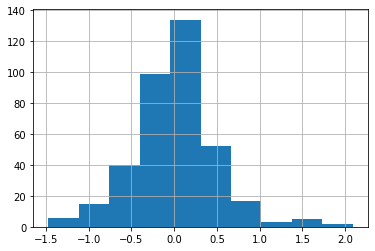

In [342]:
coef['coef'].hist()

In [359]:
coef['coef'].min(),coef['coef'].max(),coef['coef'].mean(),coef['coef'].median(),coef['coef'].std()

(-1.4711587651950562,
 2.0896870987359883,
 0.008162344596122728,
 -0.00012002346784881175,
 0.4861317357017649)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


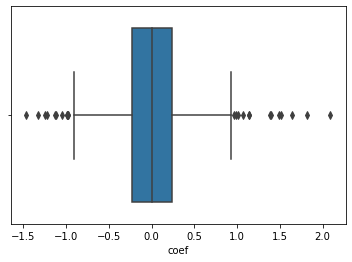

In [362]:
sns.boxplot(coef['coef'])

In [365]:
coef['coef'].quantile([.25,.5,.75])

0.25   -0.234539
0.50   -0.000120
0.75    0.236190
Name: coef, dtype: float64

In [390]:
high_coef = coef[(coef['coef']>1) | (coef['coef']<-1)]
high_coef = high_coef.rename(columns={high_coef.columns.tolist()[0]:'feature'})
high_coef

,feature,coef
21,x0_20,1.383572
27,x0_26,1.067233
63,x1_11,1.395643
72,x1_2,1.134033
79,x1_26,-1.045556
82,x1_29,-1.223611
85,x1_31,-1.471159
97,x1_42,-1.121587
104,x1_7,1.645275
105,x1_8,1.014232


important columns are x0,x1,x2,x9,x10,x13,x15, we could find their original names here

In [394]:
features_high_coef = []

for col in ['x0','x1','x2','x9','x10','x13','x15']:
    features_high_coef.append(to_original_feature[col])
features_high_coef


['detailed industry recode',
 'detailed occupation recode',
 'education',
 'tax filer status',
 'detailed household and family stat',
 'country of birth father',
 'country of birth self']

important features are:

*   industry
*   occupation
*   tax filer status
*   household and family stat
*   country of birth father
*   country of birth self


We could observe more fine-grained features as well by reading data from pdf file

In [414]:
detailed_industry_codes = pd.read_csv('data/detailed_industry_codes.csv')
detailed_industry_codes.head()

,CODE,DESCRIPTION,INDUSTRY CODE -1,INDUSTRY CODE -2
0,1,Agriculture,0170 - 0180,290
1,2,Forestry logging fishing hunting and trapping,0190 - 0280,0
2,3,Mining,0370 - 0490,0
3,4,Construction,770,0
4,5,Nonmetallic mineral products,2470 - 2590,0


I could do others, in a real world, as this is demo I keep it as it is

# Grid Search and cross validation

It was slow and I only use the simple one for now

In [261]:
# grid_search = GridSearchCV(
#     pipeline, 
#     param_grid={
#         'columntransformer__pipeline-1__simpleimputer__strategy': ['mean', 'median'],
#         'logisticregression__solver': ['lbfgs', 'saga']
#         },
#     cv=5,
#     scoring="r2")

# grid_search.fit(X_train, y_train)

# grid_search.best_params_

# saving model with pickle

In [262]:
with open ('model_pickle','wb') as fi:
  pickle.dump(pipeline,fi)